# PHD Hackathon - INSOFE

# Problem Statement

# Sales forecasting of a pharmaceutical retail chain

KioMed, a huge pharmaceutical retailer, operates in in 10+ cities across India. The company has one distribution warehouse in each of the cities it operates in. Unfortunately, the warehouses are not able to consistently meet the demand of the stores in their respective cities. Kio, the parent company, being a data driven corporation wants to solve the stocking / inventory management problem using their in-house data science team.
The retailer has provided you with historical sales data and is looking to forecast the sales for the period of one month after the end of the data. These forecasts will be used to ensure that the company is able to stock its supplies of medicines in a warehouse accordingly in each city for a period of one month.


# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from time import time
import os

In [2]:
os.getcwd()

'/Users/apple/Downloads'

In [3]:
os.chdir('/Users/apple/Documents/PHDHACKATHON/Data')

# Reading Training Data

In [4]:
traindata = pd.read_csv('train_data.csv')

In [5]:
traindata

,year,month,day,city,medicine,sales
0,2015,1,2,1,1,24.0
1,2015,1,2,1,2,144.0
2,2015,1,2,1,3,84.0
3,2015,1,2,1,4,24.0
4,2015,1,2,1,5,8.0
...,...,...,...,...,...,...
22624340,2018,6,30,10,3056,8.0
22624341,2018,6,30,10,3163,16.0
22624342,2018,6,30,10,3164,8.0
22624343,2018,6,30,10,3157,4.0


In [6]:
traindata.dtypes

year          int64
month         int64
day           int64
city          int64
medicine      int64
sales       float64
dtype: object

# Converting Day,Month,Year to DateTime Object

In [7]:
traindata['date'] = pd.to_datetime(traindata[['day','month','year']])

copy of main data

In [8]:
traindata1=traindata.copy()

In [9]:
traindata = traindata[["date", 'city', 'medicine', 'sales']]

In [10]:
traindata

,date,city,medicine,sales
0,2015-01-02,1,1,24.0
1,2015-01-02,1,2,144.0
2,2015-01-02,1,3,84.0
3,2015-01-02,1,4,24.0
4,2015-01-02,1,5,8.0
...,...,...,...,...
22624340,2018-06-30,10,3056,8.0
22624341,2018-06-30,10,3163,16.0
22624342,2018-06-30,10,3164,8.0
22624343,2018-06-30,10,3157,4.0


# Taking only 2017 and 2018 data

In [11]:
traindata=traindata[traindata.date>='2017-01-01']

# Memory Optimisation of sales,date


In [12]:
for col in traindata.columns.values:
  if(col!='sales'):
    if(col!='date'):
      print("For Column:",col,",")
      print(traindata[col].memory_usage(deep=True))
      unique_col = traindata[col].unique()
      col_mapping = {categorical_level: idx for 
                                idx, categorical_level in 
                                enumerate(unique_col, 1)}
      traindata[col] = traindata[col].map(col_mapping)
      print(traindata[col].memory_usage(deep=True))
      traindata[col] = traindata[col].astype("int16")
      print(traindata[col].memory_usage(deep=True))
      print('------------------------------------')

For Column: city ,
187872432


/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


187872432


/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


117420270
------------------------------------
For Column: medicine ,
187872432
187872432
117420270
------------------------------------


In [13]:
traindata.dtypes

date        datetime64[ns]
city                 int16
medicine             int16
sales              float64
dtype: object

# Checking minimum and maximum units sold throughout the dataset

In [14]:
print(traindata.sales.min())
print(traindata.sales.max())

-9948.0
82992.0


In [15]:
traindata.sales.nunique()

125774

# Dropping rows with negative unit sales


In [16]:
traindata=traindata[traindata.sales>=0]

In [17]:
traindata.sales.nunique()

125615

In [18]:
traindata.shape

(11741073, 4)

In [19]:
print(traindata.sales.min())



0.024


In [20]:
traindata.head()

,date,city,medicine,sales
10882318,2017-01-02,1,1,28.0
10882319,2017-01-02,1,2,72.0
10882320,2017-01-02,1,3,128.0
10882321,2017-01-02,1,4,20.0
10882322,2017-01-02,1,5,4.0


Reading Test Data

In [21]:
testdata = pd.read_csv("test_data.csv")

In [22]:
testdata.columns

Index(['id', 'year', 'month', 'day', 'city', 'medicine'], dtype='object')

In [23]:
testdata.head()

,id,year,month,day,city,medicine
0,1,2018,7,1,1,1292
1,2,2018,7,1,1,1
2,3,2018,7,1,1,2
3,4,2018,7,1,1,3
4,5,2018,7,1,1,4


# Converting Day,Month,Year to DateTime Object(TestData)


In [24]:
testdata['date'] = pd.to_datetime(testdata[['day','month','year']])

copy of Test main data

In [25]:
testdata1=testdata.copy()

In [26]:
testdata = testdata[['id','date', 'city', 'medicine']]

In [27]:
testdata.head()

,id,date,city,medicine
0,1,2018-07-01,1,1292
1,2,2018-07-01,1,1
2,3,2018-07-01,1,2
3,4,2018-07-01,1,3
4,5,2018-07-01,1,4


In [28]:
testdata.columns

Index(['id', 'date', 'city', 'medicine'], dtype='object')

# Memory Optimisation of city, medicine and Date


In [29]:
for col in testdata.columns.values:
  if(col!='id'):
    if(col!='date'):
      print("For Column:",col,",")
      print(testdata[col].memory_usage(deep=True))
      unique_col = testdata[col].unique()
      col_mapping = {categorical_level: idx for 
                                idx, categorical_level in 
                                enumerate(unique_col, 1)}
      testdata[col] = testdata[col].map(col_mapping)
      print(testdata[col].memory_usage(deep=True))
      testdata[col] = testdata[col].astype("int16")
      print(testdata[col].memory_usage(deep=True))
      print('------------------------------------')

For Column: city ,
6188408
6188408
1547198
------------------------------------
For Column: medicine ,
6188408
6188408
1547198
------------------------------------


In [30]:
print(traindata.head())
print("------------------------------------------------------------------------------")
print(traindata.tail())
print("------------------------------------------------------------------------------")
print(traindata.shape)

               date  city  medicine  sales
10882318 2017-01-02     1         1   28.0
10882319 2017-01-02     1         2   72.0
10882320 2017-01-02     1         3  128.0
10882321 2017-01-02     1         4   20.0
10882322 2017-01-02     1         5    4.0
------------------------------------------------------------------------------
               date  city  medicine  sales
22624340 2018-06-30    10      2995    8.0
22624341 2018-06-30    10      3104   16.0
22624342 2018-06-30    10      3105    8.0
22624343 2018-06-30    10      3098    4.0
22624344 2018-06-30    10      3106   56.0
------------------------------------------------------------------------------
(11741073, 4)


In [31]:
print(testdata.head())
print("-------------------------------------------------------------------------------")
print(testdata.tail())
print("-------------------------------------------------------------------------------")
print(testdata.shape)

   id       date  city  medicine
0   1 2018-07-01     1         1
1   2 2018-07-01     1         2
2   3 2018-07-01     1         3
3   4 2018-07-01     1         4
4   5 2018-07-01     1         5
-------------------------------------------------------------------------------
            id       date  city  medicine
773530  773531 2018-07-31    10      2577
773531  773532 2018-07-31    10      2578
773532  773533 2018-07-31    10      2579
773533  773534 2018-07-31    10      2580
773534  773535 2018-07-31    10      2582
-------------------------------------------------------------------------------
(773535, 4)


In [32]:
testdata.columns

Index(['id', 'date', 'city', 'medicine'], dtype='object')

In [33]:
traindata.columns

Index(['date', 'city', 'medicine', 'sales'], dtype='object')

In [34]:
testdata.dtypes

id                   int64
date        datetime64[ns]
city                 int16
medicine             int16
dtype: object

In [35]:
traindata.dtypes

date        datetime64[ns]
city                 int16
medicine             int16
sales              float64
dtype: object

In [36]:
traindata.head()

,date,city,medicine,sales
10882318,2017-01-02,1,1,28.0
10882319,2017-01-02,1,2,72.0
10882320,2017-01-02,1,3,128.0
10882321,2017-01-02,1,4,20.0
10882322,2017-01-02,1,5,4.0


In [37]:
testdata.head()

,id,date,city,medicine
0,1,2018-07-01,1,1
1,2,2018-07-01,1,2
2,3,2018-07-01,1,3
3,4,2018-07-01,1,4
4,5,2018-07-01,1,5


In [38]:
traindata.describe(include='all')

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,city,medicine,sales
count,11741073,1.174107e+07,1.174107e+07,1.174107e+07
unique,543,NaN,NaN,NaN
top,2018-02-28 00:00:00,NaN,NaN,NaN
freq,49607,NaN,NaN,NaN
first,2017-01-02 00:00:00,NaN,NaN,NaN
last,2018-06-30 00:00:00,NaN,NaN,NaN
mean,NaN,5.496904e+00,1.346035e+03,5.062506e+01
std,NaN,2.849422e+00,8.605191e+02,1.096734e+02
min,NaN,1.000000e+00,1.000000e+00,2.400000e-02
25%,NaN,3.000000e+00,6.140000e+02,1.200000e+01


In [39]:
testdata.describe(include='all')

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,date,city,medicine
count,773535.000000,773535,773535.000000,773535.000000
unique,NaN,31,NaN,NaN
top,NaN,2018-07-03 00:00:00,NaN,NaN
freq,NaN,26510,NaN,NaN
first,NaN,2018-07-01 00:00:00,NaN,NaN
last,NaN,2018-07-31 00:00:00,NaN,NaN
mean,386768.000000,NaN,5.498414,1457.533107
std,223300.464575,NaN,2.845757,871.042713
min,1.000000,NaN,1.000000,1.000000
25%,193384.500000,NaN,3.000000,705.000000


In [40]:
traindata.isnull().sum()

date        0
city        0
medicine    0
sales       0
dtype: int64

In [41]:
testdata.isna().sum()

id          0
date        0
city        0
medicine    0
dtype: int64

In [42]:
traindata.shape

(11741073, 4)

In [43]:
testdata.shape

(773535, 4)

In [44]:
traindata.dtypes

date        datetime64[ns]
city                 int16
medicine             int16
sales              float64
dtype: object

In [45]:
testdata.dtypes

id                   int64
date        datetime64[ns]
city                 int16
medicine             int16
dtype: object

In [46]:
for i in traindata.select_dtypes(['integer']):
  traindata[i]=traindata[i].astype('category')

In [47]:
for i in testdata.select_dtypes(['integer']):
  testdata[i]=testdata[i].astype('category')


In [48]:
traindata.dtypes

date        datetime64[ns]
city              category
medicine          category
sales              float64
dtype: object

In [49]:
testdata.dtypes

id                category
date        datetime64[ns]
city              category
medicine          category
dtype: object

In [50]:
traindata['sales']=traindata['sales'].astype('float32')

Performing Normalisation to Date object

In [51]:
traindata['date'] = traindata['date'].astype('datetime64[ns]').dt.normalize()
testdata['date'] = testdata['date'].astype('datetime64[ns]').dt.normalize()

In [52]:
traindata.dtypes

date        datetime64[ns]
city              category
medicine          category
sales              float32
dtype: object

In [53]:
testdata.dtypes

id                category
date        datetime64[ns]
city              category
medicine          category
dtype: object

Converting Date into Numeric type

In [54]:
traindata['date']=traindata['date'].map(datetime.datetime.toordinal)

In [55]:
traindata.dtypes

date           int64
city        category
medicine    category
sales        float32
dtype: object

In [56]:
testdata['date']=testdata['date'].map(datetime.datetime.toordinal)

In [57]:
testdata.dtypes

id          category
date           int64
city        category
medicine    category
dtype: object

In [58]:
test_id = testdata['id']
testdata.drop('id',axis=1,inplace=True)

In [59]:
testdata.columns

Index(['date', 'city', 'medicine'], dtype='object')

In [60]:
type(test_id)

pandas.core.series.Series

In [61]:
test_id = test_id.ravel()
print(test_id)

[1, 2, 3, 4, 5, ..., 773531, 773532, 773533, 773534, 773535]
Length: 773535
Categories (773535, int64): [1, 2, 3, 4, ..., 773532, 773533, 773534, 773535]


In [62]:
type(test_id)

pandas.core.arrays.categorical.Categorical

In [63]:
y=traindata["sales"]
X=traindata.drop('sales', axis=1)

In [64]:
cat_attr = list(X.select_dtypes("category").columns)
cat_attr


['city', 'medicine']

In [65]:
num_attr = list(X.columns.difference(cat_attr))
num_attr

['date']

Using Pipeline to treat numeric and categorical variables

In [66]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])



categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

# Splitting the Data into Train and Test 

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)

# ModelBuilding

# LinearRegression

In [68]:
lin_reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [69]:
lin_reg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['date']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'medicine'])])),
                ('regressor', LinearRegression())])

In [70]:
train_pred =lin_reg.predict(X_train)
val_pred = lin_reg.predict(X_val)

In [71]:
val_pred

array([60.65439918, 70.42732752, 42.55863863, ..., 47.28394392,
       22.06613085, 76.05282882])

In [72]:
test_pred = lin_reg.predict(testdata)

In [73]:
test_pred

array([ 30.2629797 ,  88.43303791, 139.7680586 , ...,  36.42384984,
        70.51253192,  43.72177233])

Mean Absolute Percentage Error function

In [77]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [86]:
mean_absolute_percentage_error(y_val,val_pred)

129.99837506776316

Calculating MSE and RMSE on Train and Test

In [78]:
import sklearn
import math

In [79]:
mse1 = sklearn.metrics.mean_squared_error(y_train, train_pred)

In [80]:
mse1

7271.586092910492

In [81]:
rmse1 = math.sqrt(mse1)

In [82]:
rmse1

85.2735955200113

In [83]:
mse2 = sklearn.metrics.mean_squared_error(y_val, val_pred)

In [84]:
rmse2 = math.sqrt(mse2)

In [85]:
rmse2

78.12191564933937

R square

In [87]:
r2 = r2_score(y_val,val_pred)

In [88]:
r2

0.45552482587663634

Plotting the residuals

<AxesSubplot:xlabel='sales'>

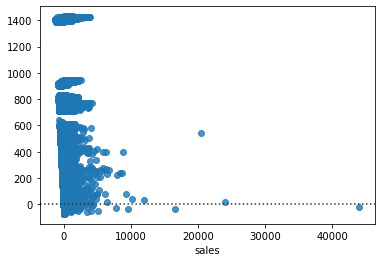

In [89]:
sns.residplot(y_val-val_pred,val_pred)

Saving the predictions to a CSV file

In [90]:
lin= {"id":test_id,"sales":test_pred}
pd.DataFrame(lin).to_csv("LinearRegressionFl.csv",index=False)

Elastic Nets Model

In [91]:
en_reg=Pipeline(steps=[('preprocessor',preprocessor),('Elastic Nets',ElasticNet(alpha=0.5,l1_ratio=0.5))])

In [92]:
en_reg.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['date']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'medicine'])])),
                ('Elastic Nets', ElasticNet(alpha=0.5))])

In [93]:
train_pred_en=en_reg.predict(X_train)
val_pred_en = en_reg.predict(X_val)
test_pred_en = en_reg.predict(testdata)

In [94]:
test_pred_en

array([52.73850514, 52.73850514, 52.73850514, ..., 46.73376713,
       46.73376713, 46.73376713])

Checking Mape,RMSE on TRAINING AND TEST SET

In [95]:
mean_absolute_percentage_error(y_val,val_pred_en)

272.21791362169904

In [97]:
import sklearn
import math

In [102]:
mse = sklearn.metrics.mean_squared_error(y_train, train_pred)

In [103]:
mse

7271.586092910492

In [104]:
rmseEN = math.sqrt(mse)

In [105]:
rmseEN

85.2735955200113

In [98]:
mse2 = sklearn.metrics.mean_squared_error(y_val, val_pred_en)

In [99]:
mse2

11145.712779816002

In [100]:
rmse2 = math.sqrt(mse2)

In [101]:
rmse2

105.5732578819845

Plotting Residuals

<AxesSubplot:xlabel='sales'>

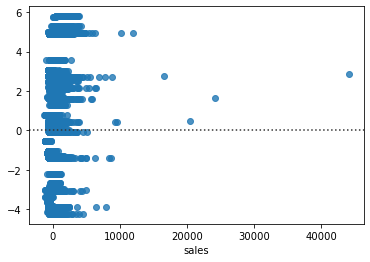

In [130]:
sns.residplot(y_val-val_pred,val_pred_en)

Saving the Predictions to CSV_File

In [106]:
en= {"id":test_id,"sales":test_pred}
pd.DataFrame(en).to_csv("ElasticnetFl.csv",index=False)

Decision Tree Modelling

In [ ]:
#from sklearn.tree import DecisionTreeRegressor

In [ ]:
#DT = Pipeline(steps=[('preprocessor', preprocessor),
                     #('regressor', DecisionTreeRegressor())])

In [ ]:
#DT.fit(X_train,y_train)

In [ ]:
#train_pred =regressor.predict(X_train)
#val_pred_Dt = regressor.predict(X_val)

In [ ]:
#test_pred_en = regressor.predict(testdata)

In [ ]:
#mean_absolute_percentage_error(y_val,val_pred_Dt)

In [ ]:
#Rsquare = r2_score(y_val,val_pred_Dt)

In [ ]:
#Rsquare

In [ ]:
#mse3 = sklearn.metrics.mean_squared_error(y_val, val_pred_Dt)

In [ ]:
#rmse3 = math.sqrt(mse3)

In [ ]:
#rmse3

In [ ]:
#Dt= {"id":test_id,"sales":test_pred}
#pd.DataFrame(Dt).to_csv("DecisionTree.csv",index=False)

# GRADIENT BOOSTING MODEL

In [107]:
import xgboost as xgb


In [108]:
XGBOOST = Pipeline(steps=[('preprocessor', preprocessor),
                    ('regressor', xgb.XGBRegressor())])

In [109]:
XGBOOST.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['date']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'medicine'])])),
                ('regressor', XGBRegressor())])

In [110]:
train_pred =XGBOOST.predict(X_train)
val_pred_XG = XGBOOST.predict(X_val)

In [111]:
test_pred_XG = XGBOOST.predict(testdata)

In [112]:
mean_absolute_percentage_error(y_val,val_pred_XG)

249.39210414886475

In [113]:
R2 = r2_score(y_val,val_pred_XG)

In [114]:
R2

0.31489243145381574

In [115]:
mse4 = sklearn.metrics.mean_squared_error(y_val, val_pred_XG)

In [116]:
mse4

7679.385

In [117]:
rmse4 = math.sqrt(mse4)

In [118]:
rmse4

87.63209894567743

In [119]:
Dt= {"id":test_id,"sales":test_pred}
pd.DataFrame(Dt).to_csv("XGBOOSTREGRESSORFinal.csv",index=False)

Reading the Test data after Predictions

In [121]:
TestDataframe=pd.read_csv('test_data.csv')


In [124]:
predictions=pd.read_csv('LinearRegressionFl.csv')

In [125]:
Test=pd.concat([TestDataframe,predictions],axis=1)

In [126]:
Test

,id,year,month,day,city,medicine,id,sales
0,1,2018,7,1,1,1292,1,30.262980
1,2,2018,7,1,1,1,2,88.433038
2,3,2018,7,1,1,2,3,139.768059
3,4,2018,7,1,1,3,4,33.693643
4,5,2018,7,1,1,4,5,19.328868
...,...,...,...,...,...,...,...,...
773530,773531,2018,7,31,10,3163,773531,21.416091
773531,773532,2018,7,31,10,3164,773532,26.379176
773532,773533,2018,7,31,10,3157,773533,36.423850
773533,773534,2018,7,31,10,3165,773534,70.512532


In [127]:
pd.DataFrame(Test).to_csv("KioMed.csv",index=False)


July month day wise predictions sales vs medicines prediction there is a proper seasonality.seasonality is observed over the weekends so it is highly recommended to stock up the stores based on the sales count of each city.

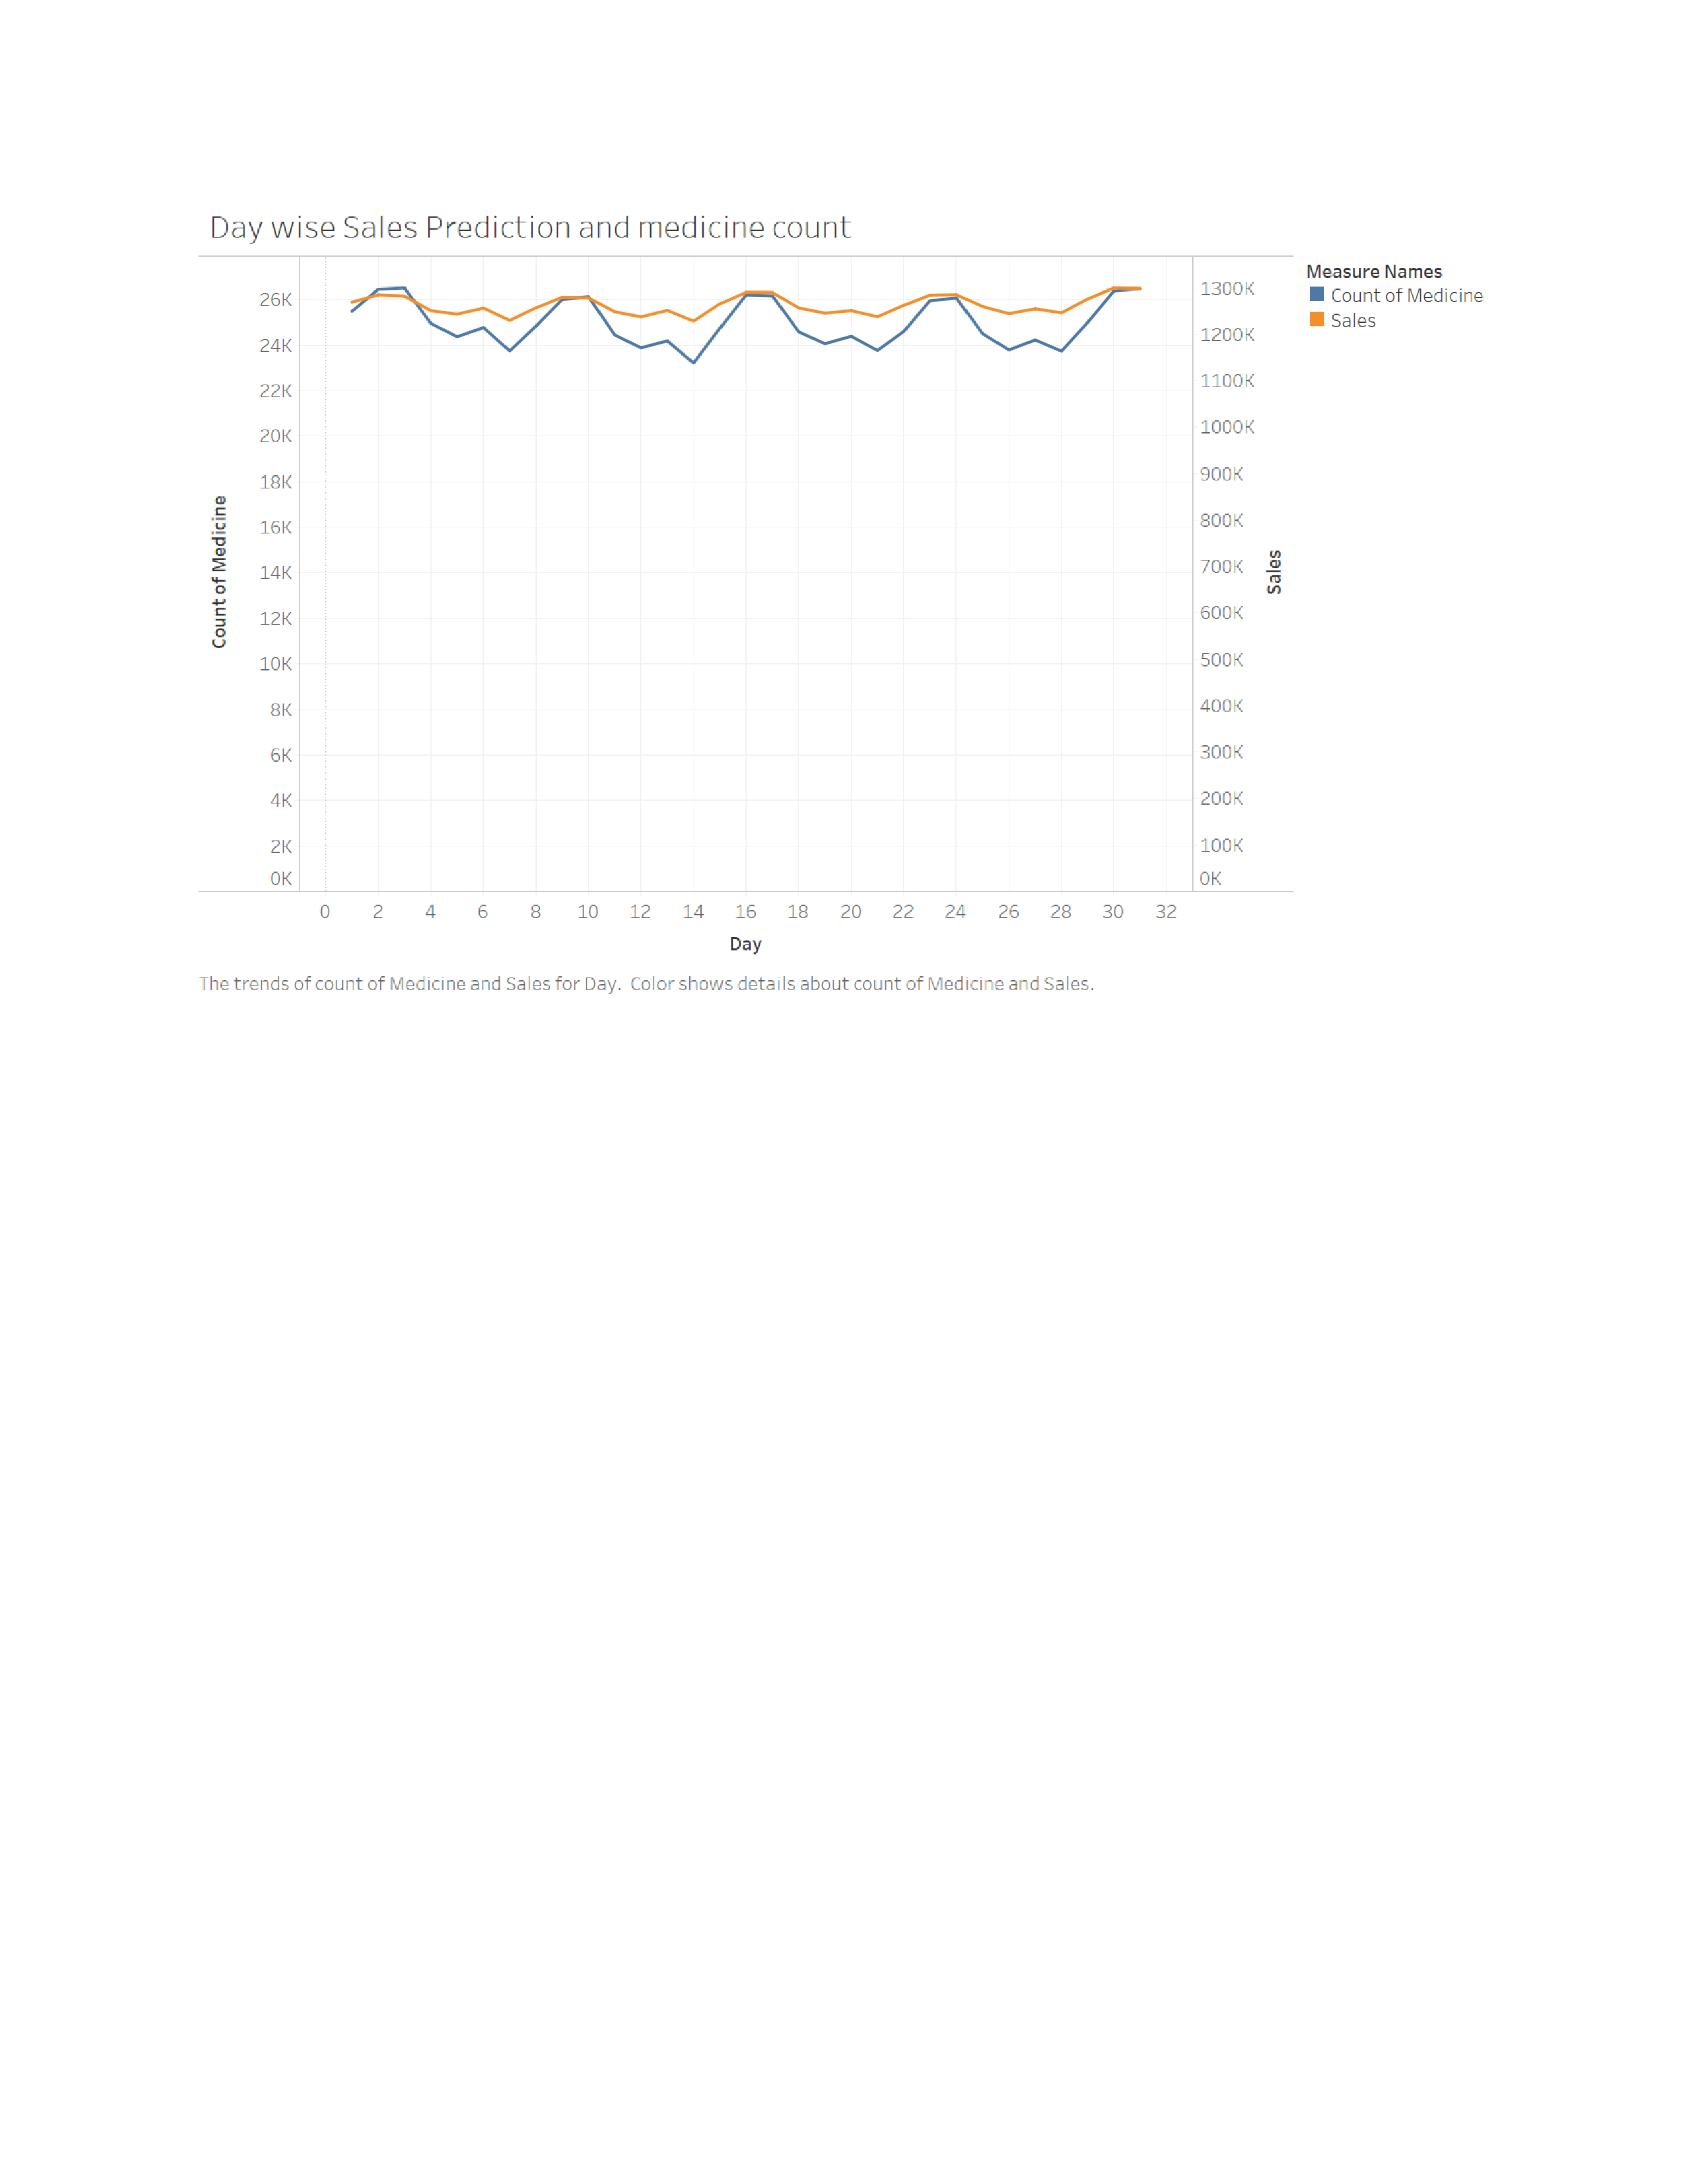

In [128]:
from IPython.display import Image
Image(filename='Daywisesales and medicine.png')

In city wise sales predicton for July 2018 we can see Highest sales was observed in Delhi and Lowest sales in Bangalore.I recommend to increase stocks as per the sales observed values .Highest sales was observed in Delhi 3978142.Lowest observed in Bangalore and others 2012278

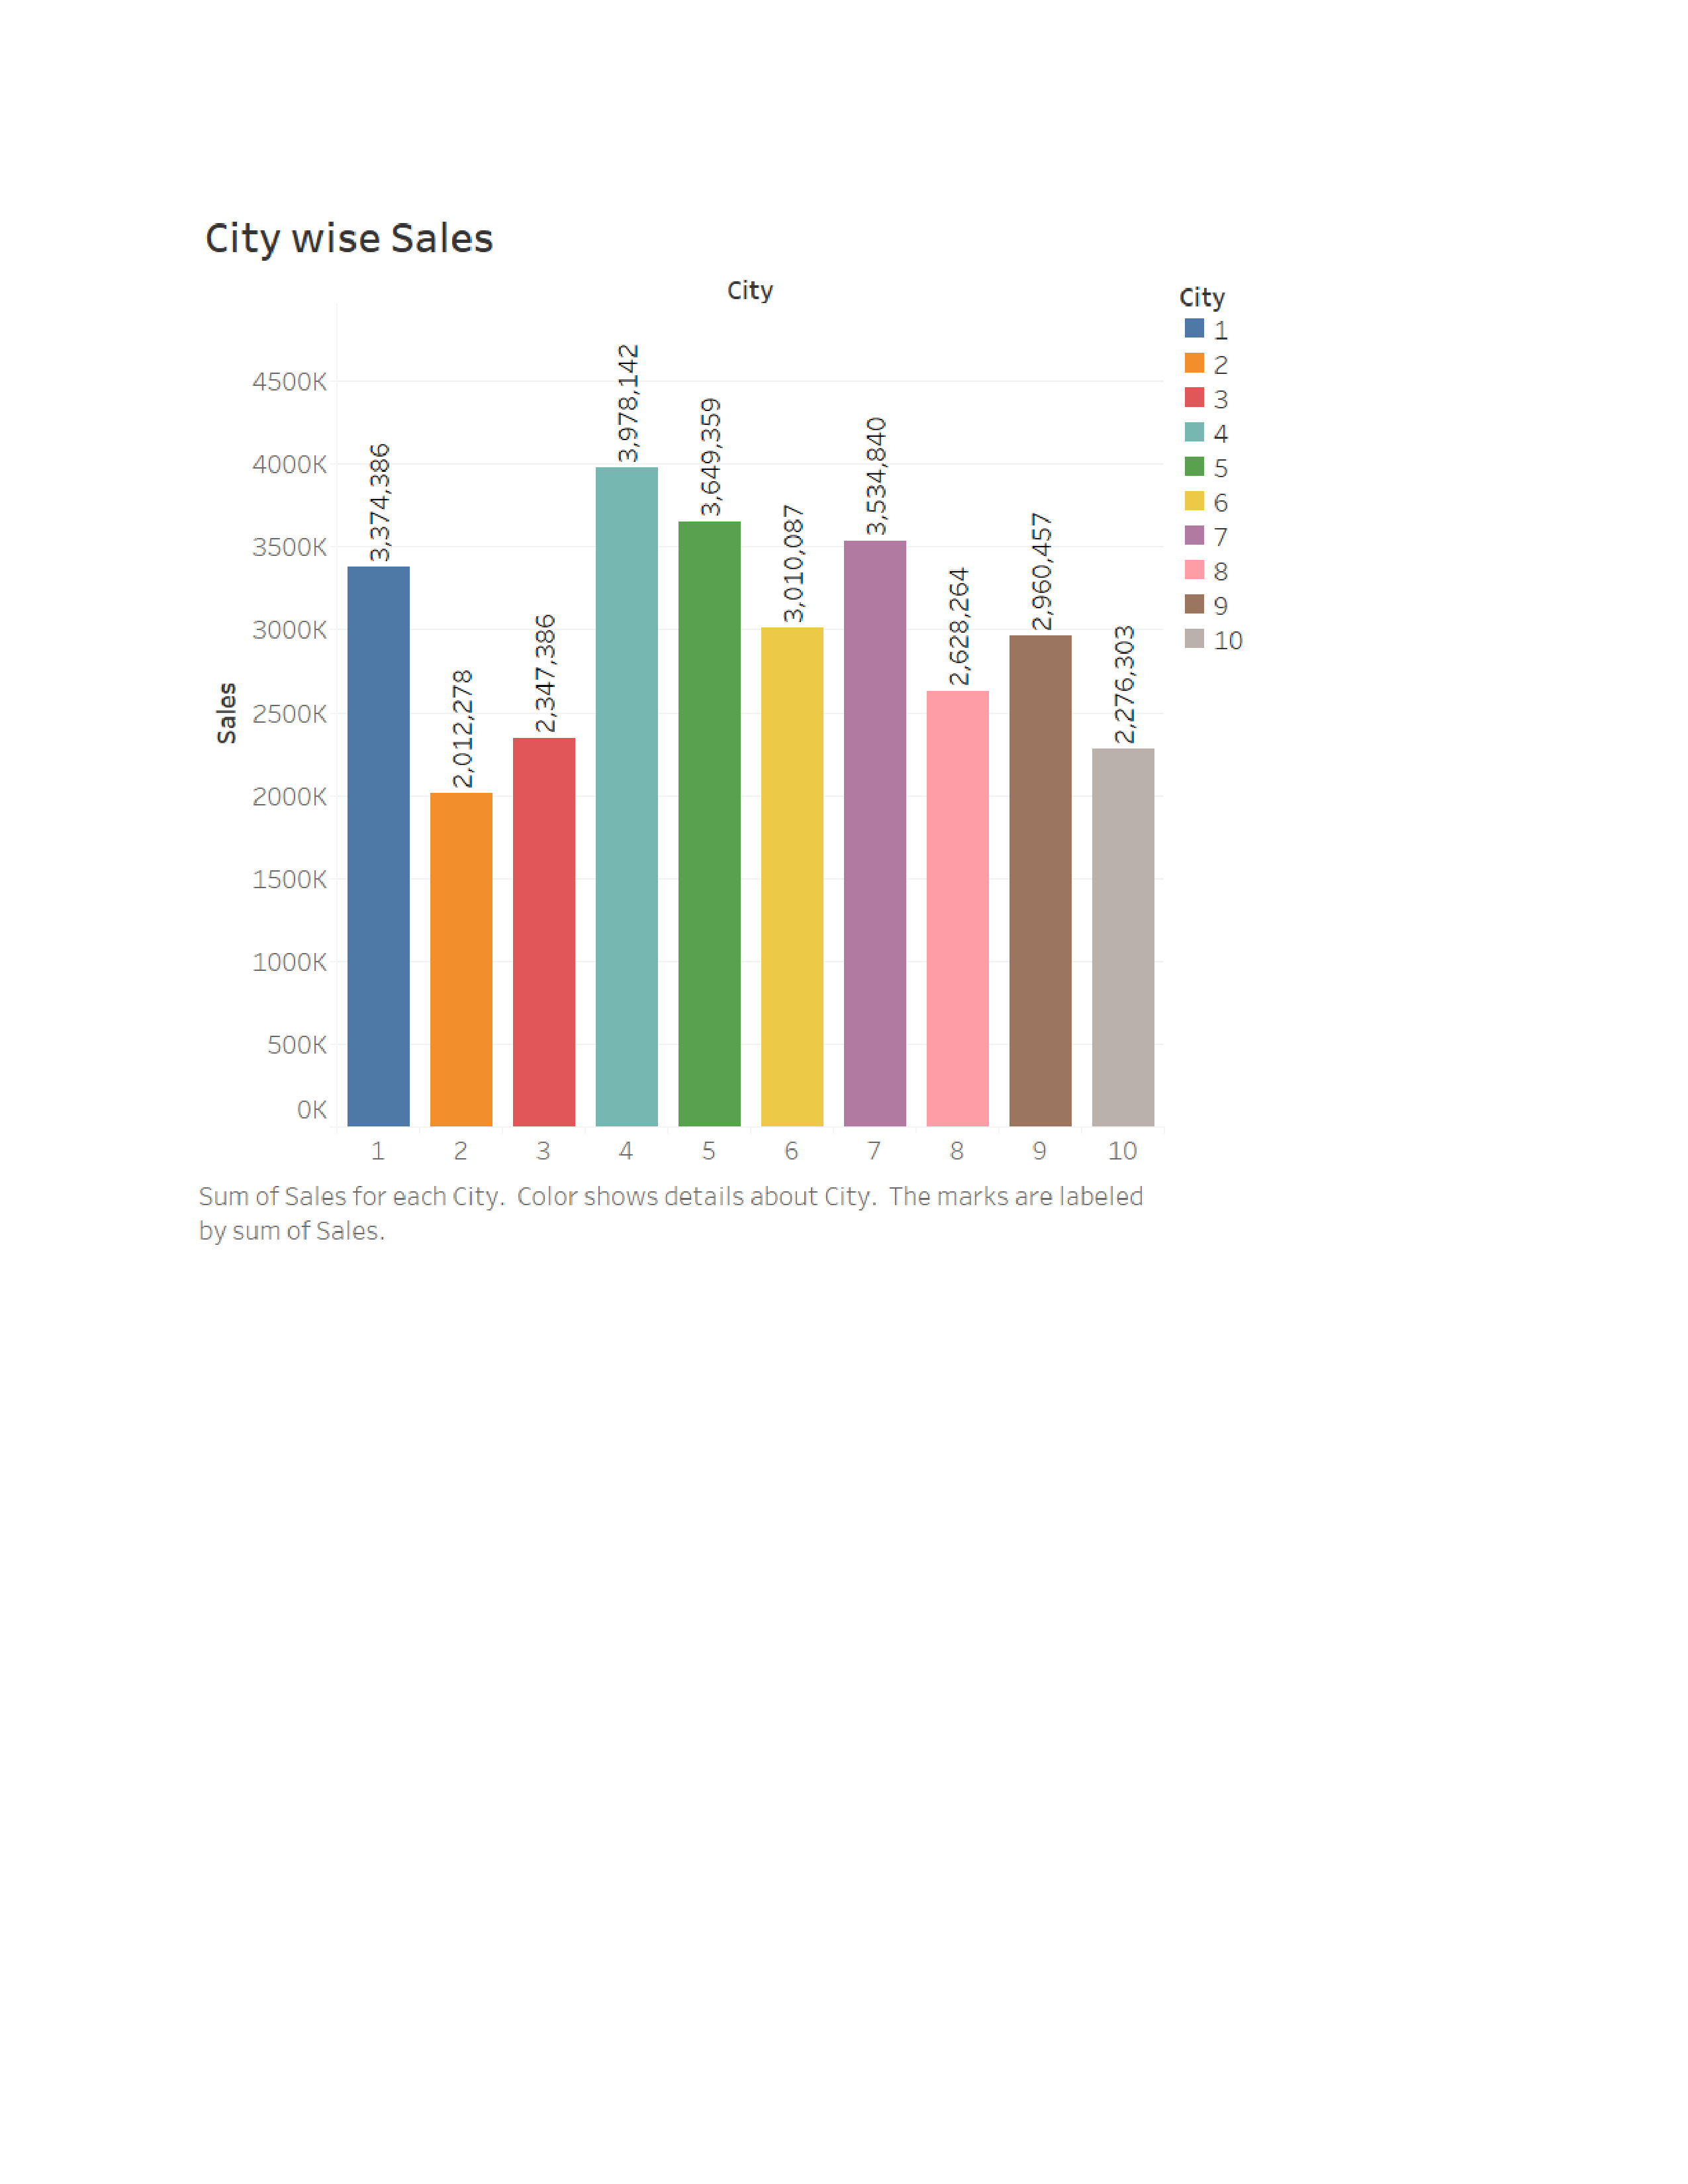

In [129]:
from IPython.display import Image
Image(filename='CITYWISESALES.png')